In [ ]:
import cv2
import numpy as np
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
from tkinter import filedialog, Tk, Button, Label

In [ ]:
input_dir = r"D:\Datasets_Assessment\Datasets\Raw_Images"
output_dir = r"D:\Datasets_Assessment\Datasets\patches"
os.makedirs(output_dir, exist_ok=True)

def create_circular_mask(h, w):
    center = (int(w/2), int(h/2))
    radius = min(center[0], center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    return dist_from_center <= radius

for fname in os.listdir(input_dir):
    if not fname.endswith(".tiff"):
        continue
    img_path = os.path.join(input_dir, fname)
    img16 = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img8 = cv2.normalize(img16, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    img_eq = clahe.apply(img8)
    blurred = cv2.GaussianBlur(img_eq, (3, 3), 0)
    _, binary = cv2.threshold(blurred, 25, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = create_circular_mask(*img8.shape)

    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 8 or area > 3000:
            continue
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        if not mask[cy, cx]:  # skip if outside circle
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        label = "star" if 0.7 < aspect_ratio < 1.5 else "streak"

        # crop patch
        r = 32
        patch = img_eq[max(0, cy-r):cy+r, max(0, cx-r):cx+r]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue

        out_path = os.path.join(output_dir, f"{label}_{fname[:-5]}_{count}.png")
        cv2.imwrite(out_path, patch)
        count += 1


In [ ]:
base_dir = r"D:\Datasets_Assessment\Datasets\patches"
dest_dirs = {
    "star": os.path.join(base_dir, "star"),
    "streak": os.path.join(base_dir, "streak")
}

# Create subfolders if they don't exist
for folder in dest_dirs.values():
    os.makedirs(folder, exist_ok=True)

# Valid image extensions
image_extensions = ('.tiff')

# Move files based on filename
moved = 0
skipped = 0
for filename in os.listdir(base_dir):
    src_path = os.path.join(base_dir, filename)
    if os.path.isfile(src_path) and filename.lower().endswith(image_extensions):
        lowered = filename.lower()
        if "star" in lowered:
            shutil.move(src_path, os.path.join(dest_dirs["star"], filename))
            moved += 1
        elif "streak" in lowered:
            shutil.move(src_path, os.path.join(dest_dirs["streak"], filename))
            moved += 1
        else:
            print(f"Skipping file without 'star' or 'streak' in name: {filename}")
            skipped += 1

print(f"Moved {moved} files.")
if skipped > 0:
    print(f"Skipped {skipped} files.")


Moved 901 files.


Epoch 1 - Loss: 0.2507 - Accuracy: 91.90%
Epoch 2 - Loss: 0.1791 - Accuracy: 92.67%
Epoch 3 - Loss: 0.1284 - Accuracy: 92.90%
Epoch 4 - Loss: 0.1253 - Accuracy: 93.78%
Epoch 5 - Loss: 0.1095 - Accuracy: 94.56%
Epoch 6 - Loss: 0.1214 - Accuracy: 93.01%
Epoch 7 - Loss: 0.1014 - Accuracy: 94.67%
Epoch 8 - Loss: 0.0986 - Accuracy: 94.67%
Epoch 9 - Loss: 0.0993 - Accuracy: 94.78%
Epoch 10 - Loss: 0.1037 - Accuracy: 94.67%
Epoch 11 - Loss: 0.0996 - Accuracy: 94.67%
Epoch 12 - Loss: 0.0939 - Accuracy: 94.56%
Epoch 13 - Loss: 0.0969 - Accuracy: 94.67%
Epoch 14 - Loss: 0.0984 - Accuracy: 94.67%
Epoch 15 - Loss: 0.1062 - Accuracy: 94.67%
Epoch 16 - Loss: 0.1234 - Accuracy: 93.56%
Epoch 17 - Loss: 0.0995 - Accuracy: 94.67%
Epoch 18 - Loss: 0.0964 - Accuracy: 94.67%
Epoch 19 - Loss: 0.0932 - Accuracy: 94.67%
Epoch 20 - Loss: 0.0938 - Accuracy: 94.78%
Epoch 21 - Loss: 0.0983 - Accuracy: 94.23%
Epoch 22 - Loss: 0.0882 - Accuracy: 94.78%
Epoch 23 - Loss: 0.0946 - Accuracy: 94.89%
Epoch 24 - Loss: 0.1

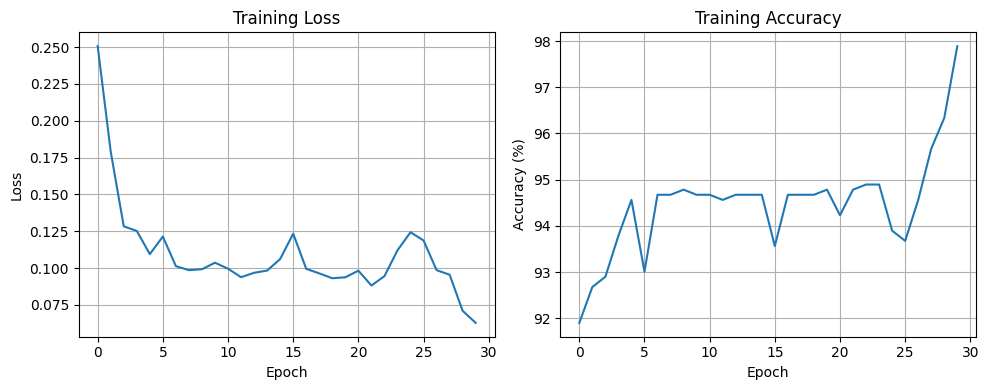

In [ ]:
# Dataset and transforms
output_dir = r"D:\Datasets_Assessment\Datasets\patches"
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
dataset = datasets.ImageFolder(root=output_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
class_names = dataset.classes

# Model setup
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(30):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%")

# Save model
torch.save(model.state_dict(), "star_streak_cnn.pth")


# Plot Loss and Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Load CNN model
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("D:\star_streak_cnn.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Transform for input to model
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Output folder
output_dir = r"D:\Datasets_Assessment\Datasets\CNN_Annotated"
os.makedirs(output_dir, exist_ok=True)

def process_image(image_path):
    # Read and preprocess
    img16 = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img8 = cv2.normalize(img16, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    img_eq = clahe.apply(img8)
    blurred = cv2.GaussianBlur(img_eq, (3, 3), 0)
    _, binary = cv2.threshold(blurred, 25, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = cv2.cvtColor(img8, cv2.COLOR_GRAY2BGR)
    bright_output = cv2.convertScaleAbs(output, alpha=2.5, beta=80)

    mask = np.zeros(img8.shape, dtype=np.uint8)
    cv2.circle(mask, (img8.shape[1]//2, img8.shape[0]//2), img8.shape[0]//2, 255, -1)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 8 or area > 3000:
            continue
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        if mask[cy, cx] == 0:
            continue

        r = 32
        patch = img_eq[max(0, cy-r):cy+r, max(0, cx-r):cx+r]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue

        pil_patch = Image.fromarray(patch)
        input_tensor = transform(pil_patch).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(input_tensor)
            label = "star" if torch.argmax(pred) == 0 else "streak"

        cv2.circle(bright_output, (cx, cy), 6, (255, 255, 255), -1)
        cv2.putText(bright_output, label, (cx + 10, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    bright_output[mask == 0] = 0

    # Save result
    base = os.path.basename(image_path)
    save_path = os.path.join(output_dir, os.path.splitext(base)[0] + "_annotated.png")
    cv2.imwrite(save_path, bright_output)
    print(f"Saved annotated result to {save_path}")

def upload_image():
    file_path = filedialog.askopenfilename(filetypes=[("TIFF files", "*.tiff"), ("All files", "*.*")])
    if file_path:
        process_image(file_path)
        status_label.config(text="Image processed and saved")

# GUI setup
root = Tk()
root.title("Star/Streak CNN Annotator")
root.geometry("400x200")

upload_btn = Button(root, text="Upload .tiff Image", command=upload_image, height=2, width=25)
upload_btn.pack(pady=30)

status_label = Label(root, text="")
status_label.pack()

root.mainloop()


In [ ]:
# Paths
input_dir = r"D:\Datasets_Assessment\Datasets\Raw_Images"
output_dir = r"D:\Datasets_Assessment\Datasets\CNN_Annotated"
os.makedirs(output_dir, exist_ok=True)

# Model setup
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(r"D:\Datasets_Assessment\Datasets\star_streak_cnn.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Loop over .tiff files
for file in os.listdir(input_dir):
    if not file.lower().endswith(".tiff"):
        continue

    image_path = os.path.join(input_dir, file)
    img16 = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img8 = cv2.normalize(img16, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    img_eq = clahe.apply(img8)
    blurred = cv2.GaussianBlur(img_eq, (3, 3), 0)
    _, binary = cv2.threshold(blurred, 25, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = cv2.cvtColor(img8, cv2.COLOR_GRAY2BGR)
    bright_output = cv2.convertScaleAbs(output, alpha=2.5, beta=80)

    # Circular mask
    mask = np.zeros(img8.shape, dtype=np.uint8)
    cv2.circle(mask, (img8.shape[1]//2, img8.shape[0]//2), img8.shape[0]//2, 255, -1)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 8 or area > 3000:
            continue

        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        if mask[cy, cx] == 0:
            continue

        r = 32
        patch = img_eq[max(0, cy-r):cy+r, max(0, cx-r):cx+r]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue

        pil_patch = Image.fromarray(patch)
        input_tensor = transform(pil_patch).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(input_tensor)
            label = "star" if torch.argmax(pred) == 0 else "streak"

        cv2.circle(bright_output, (cx, cy), 6, (255, 255, 255), -1)
        cv2.putText(bright_output, label, (cx + 10, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Apply circular mask to final image
    circular_mask = mask > 0
    bright_output[~circular_mask] = 0

    save_path = os.path.join(output_dir, os.path.splitext(file)[0] + "_annotated.png")
    cv2.imwrite(save_path, bright_output)
    print(f"Saved annotated result: {save_path}")


Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_001_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_002_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_003_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_004_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_005_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_006_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_007_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_008_Set1_annotated.png
Saved annotated result: D:\Datasets_Assessment\Datasets\CNN_Annotated\Raw_Observation_009_Set1_annotated.png
Saved annotated res